In [ ]:
import sys
import os
sys.path.append("/home/luke/VIU/09MIAR/src")

from vae.datasets.audio_dataset import AudioDataset
from vae.datasets.mp3_validator import MP3ValidatorDataset
from vae.datasources.fma_datasource import FMADatasource
import torch
from torch.utils.data import DataLoader

from dotenv import load_dotenv
load_dotenv('./VIU/09MIAR/src/vae/.env')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

datasets_path = '/home/luke/VIU/09MIAR/datasets'
valid_files_csv_path = '/home/luke/valid_files.csv'

def get_dataloader(datasets_path, valid_files_csv_path, num_mels):
    fma_dataset = FMADatasource(datasets_path)

    file_paths = fma_dataset.get_file_paths()
    labels = fma_dataset.get_labels()
    mp3Validator = MP3ValidatorDataset(file_paths,labels,valid_files_csv_path,num_mels,10,25,int(os.environ.get('SAMPLE_RATE')))
     
    num_tracks_per_genre, dict_dataset = fma_dataset.balanced(mp3Validator.getValidFiles() ,int(os.environ.get('LIMIT_FILES'))) # TODO: REMOVE -> limited to 500

    file_paths = list(dict_dataset.keys())
    labels = [dict_dataset[fp]['label'] for fp in file_paths]

    dataset = AudioDataset(file_paths, labels)
    print('dataset done')
    
    # dataloader = DataLoader(dataset, int(os.environ.get('TRAIN_BATCH_SIZE')), shuffle=False, drop_last=True, pin_memory=False)
    dataloader = DataLoader(dataset, int(os.environ.get('TRAIN_BATCH_SIZE')), shuffle=True, num_workers=30)
    print('dataloader done')

    return dataloader, dataset

dataloader, dataset = get_dataloader(datasets_path, valid_files_csv_path, int(os.environ.get('NUM_MELS')))


Creating valid_files
done valid_files
dataset done
dataloader done


In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE_Encoder(nn.Module):
    def __init__(self):
        super(VAE_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.pad(x, (0, 0, 1, 1))  # padding en altura
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x


class VAE_Decoder(nn.Module):
    def __init__(self):
        super(VAE_Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))

        x = x[:, :, :128, :2510]
        return x



class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = VAE_Encoder()
        self.decoder = VAE_Decoder()

    def forward(self, x):
        print(x.shape)
        z = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x


class LitVAE(pl.LightningModule):
    def __init__(self, latent_dim=128, learning_rate=1e-3):
        super(LitVAE, self).__init__()
        self.model = VAE()
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        reconstructed_x = self(x)
        loss = ((reconstructed_x - x) ** 2).mean()
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:

model = LitVAE(latent_dim=128)


trainer = pl.Trainer(max_epochs=1)


trainer.fit(model, dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | VAE  | 185 K  | train
---------------------------------------
185 K     Trainable params
0         Non-trainable params
185 K     Total params
0.741     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8,

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8,

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8,

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8,

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8, 1, 128, 505])
torch.Size([8,

`Trainer.fit` stopped: `max_epochs=1` reached.


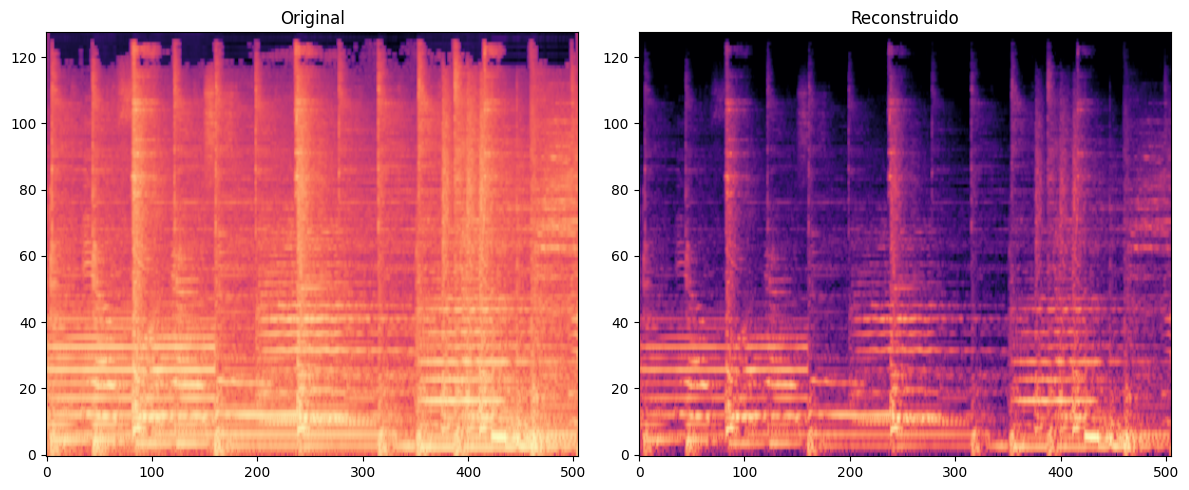

In [4]:
import matplotlib.pyplot as plt


model.eval()


with torch.no_grad():
    for batch in dataloader:
        x, _ = batch
        x = x.to(model.device)

        reconstructed_x = model(x)


        original = x[0].squeeze().cpu().numpy()
        reconstruido = reconstructed_x[0].squeeze().cpu().numpy()


        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs[0].imshow(original, aspect='auto', origin='lower', cmap='magma')
        axs[0].set_title("Original")
        axs[1].imshow(reconstruido, aspect='auto', origin='lower', cmap='magma')
        axs[1].set_title("Reconstruido")
        plt.tight_layout()
        plt.show()

        break


Shape del batch completo (x): torch.Size([8, 1, 128, 505])
Shape del target (y): torch.Size([8])

Ejemplo individual:
Shape del ejemplo: torch.Size([1, 128, 505])


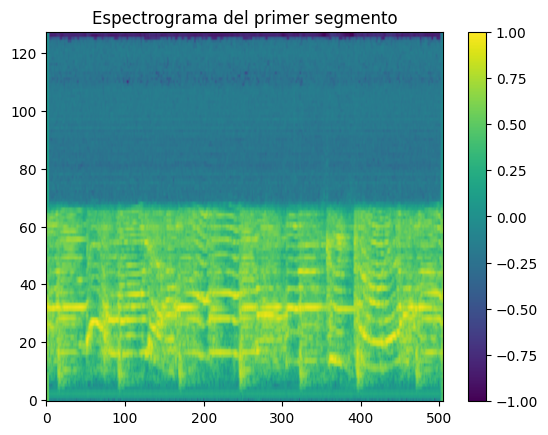

In [5]:

batch = next(iter(dataloader))


x, y = batch

print("Shape del batch completo (x):", x.shape)
print("Shape del target (y):", y.shape if y is not None else "None")


print("\nEjemplo individual:")
ejemplo = x[0]
print("Shape del ejemplo:", ejemplo.shape)


import matplotlib.pyplot as plt

if ejemplo.ndim == 3:

    plt.imshow(ejemplo.squeeze().cpu(), aspect='auto', origin='lower')
    plt.title("Espectrograma del primer segmento")
    plt.colorbar()
    plt.show()
elif ejemplo.ndim == 4:

    print("Número de segmentos:", ejemplo.shape[0])
    fig, axs = plt.subplots(1, ejemplo.shape[0], figsize=(15, 3))
    for i in range(ejemplo.shape[0]):
        axs[i].imshow(ejemplo[i].squeeze().cpu(), aspect='auto', origin='lower')
        axs[i].set_title(f"Segmento {i+1}")
    plt.show()
else:
    print("Formato no esperado.")
